In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import joblib
from pathlib import Path
import pickle
import gpytorch
import json

In [3]:
from models import Ridge
from gp_models import ExactGPModel

In [4]:
df_data = pd.read_csv('../out/ensemble-multidomain/data-stage2/phase1-ood/ood6-weak48s-opt/test-X.csv', index_col=0)
column_names = df_data.columns.values
column_names

array(['pred-pretty-sound-7', 'pred-rural-river-8', 'pred-fancy-music-9',
       'pred-golden-monkey-10', 'pred-peachy-valley-11',
       'pred-spring-lake-12', 'pred-phase1-main---ridge---w2v_small',
       'pred-phase1-main---ridge---w2v_large',
       'pred-phase1-main---ridge---w2v_large2',
       'pred-phase1-main---ridge---w2v_xlsr',
       'pred-phase1-main---ridge---hubert_base',
       'pred-phase1-main---ridge---hubert_large',
       'pred-phase1-main---ridge---wavlm_base',
       'pred-phase1-main---ridge---wavlm_large',
       'pred-phase1-main---linear_svr---w2v_small',
       'pred-phase1-main---linear_svr---w2v_large',
       'pred-phase1-main---linear_svr---w2v_large2',
       'pred-phase1-main---linear_svr---w2v_xlsr',
       'pred-phase1-main---linear_svr---hubert_base',
       'pred-phase1-main---linear_svr---hubert_large',
       'pred-phase1-main---linear_svr---wavlm_base',
       'pred-phase1-main---linear_svr---wavlm_large',
       'pred-phase1-main---kernel_svr-

In [57]:
df_weight_list = []
for i in range(5):
    ridge_model = joblib.load(f'../out/ensemble-multidomain/stage2/phase1-ood/ridge-ood6-weak48s-opt/{i}/model.joblib')
    df_weight_list.append(pd.Series(dict(zip(column_names, ridge_model.coef_))))
df_weight = pd.concat(df_weight_list, axis=1)
df_weight.shape


(198, 5)

In [58]:
df_weight.columns.values


array([0, 1, 2, 3, 4])

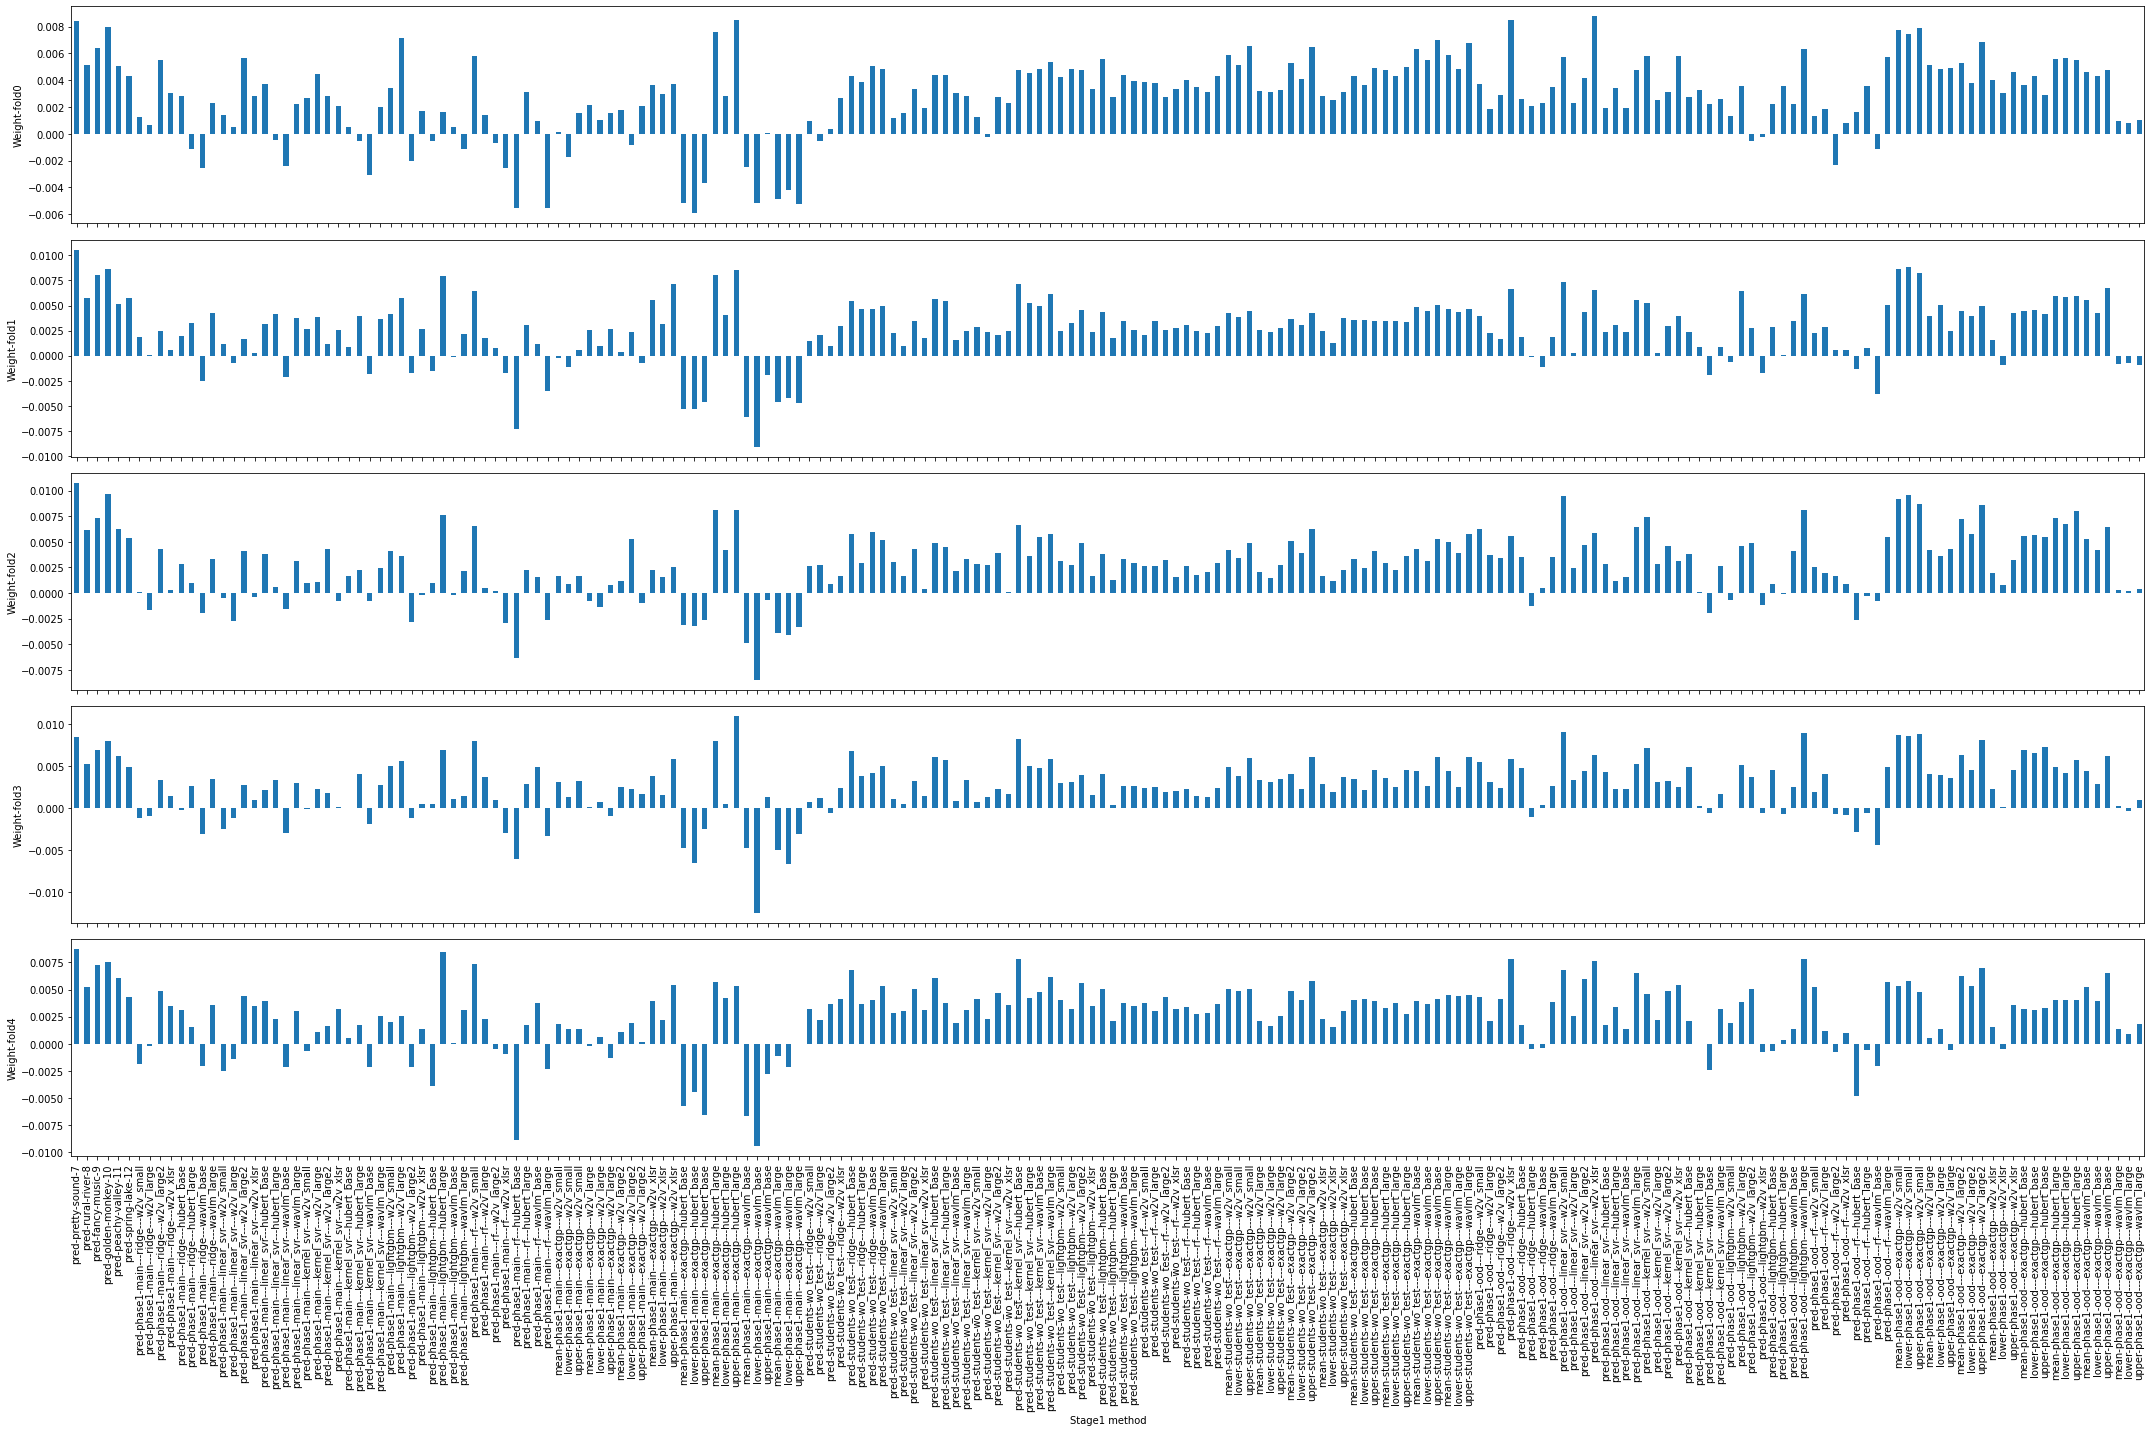

In [61]:
fig, axes = plt.subplots(5,1,figsize=(30,20), sharex=True)
for i in range(5):
    ax = axes[i]
    df_weight.loc[:, i].plot.bar(ax=ax)
    ax.set_ylabel(f'Weight-fold{i}')
    ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/ood-ridge_coef.pdf')

In [10]:
# !mkdir -p fig

In [40]:
# initial_inducing = torch.from_numpy(np.empty((1024, len(column_names)), dtype=np.float32))
# initial_inducing.size()

torch.Size([1024, 43])

In [63]:
df_lengthscale_list = []
for i in range(5):
    model_dir = Path(f'../out/ensemble-multidomain/stage2/phase1-ood/exactgp-ood6-weak48s-opt/{i}')
    conf = json.load(open(model_dir / 'model_config.json', 'rb'))
    dummy_X = torch.from_numpy(
        np.empty(conf['input_shape'], dtype=np.float32))
    dummy_y = torch.from_numpy(
        np.empty(conf['output_shape'], dtype=np.float32))
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
                    noise_constraint=gpytorch.constraints.GreaterThan(1e-3),
                )
    gpr = ExactGPModel(dummy_X, dummy_y, likelihood,
                        initial_lengthscale=1.0)
    gpr.load_state_dict(torch.load(model_dir / 'model.pt', map_location='cpu'))
    lengthscale = gpr.covar_module.base_kernel.lengthscale.detach().numpy().ravel()
    df_lengthscale_list.append(pd.Series(dict(zip(column_names, lengthscale))))
    
df_lengthscale = pd.concat(df_lengthscale_list, axis=1)
df_lengthscale.shape
    
    

(198, 5)

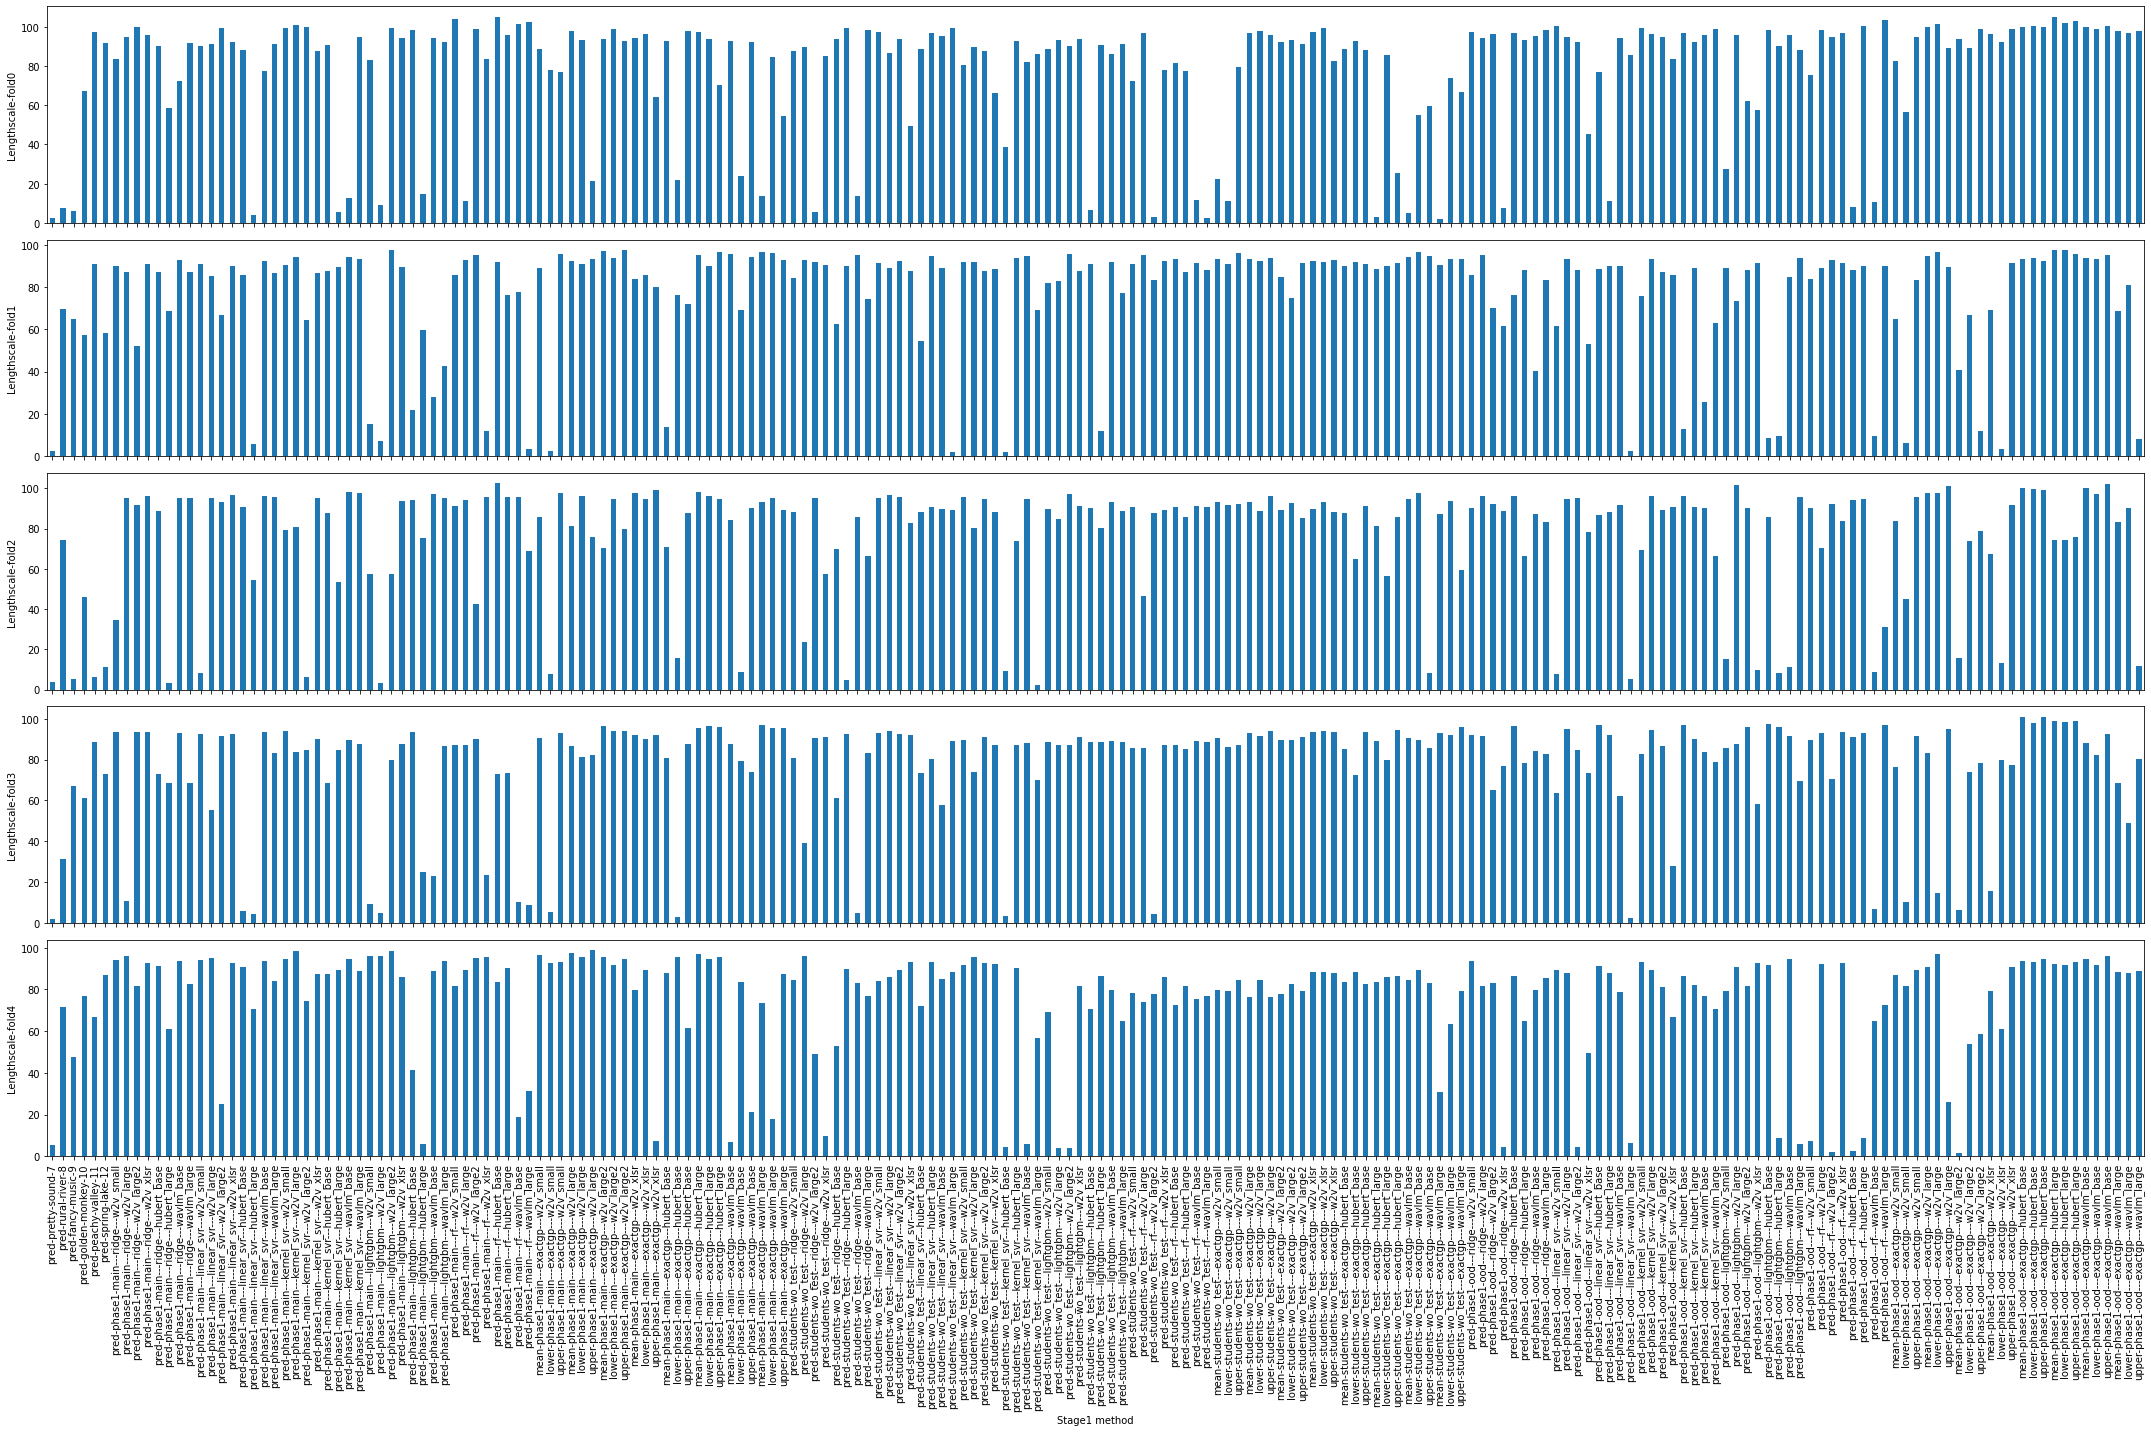

In [64]:
fig, axes = plt.subplots(5,1,figsize=(30,20), sharex=True)
for i in range(5):
    ax = axes[i]
    df_lengthscale.loc[:, i].plot.bar(ax=ax)
    ax.set_ylabel(f'Lengthscale-fold{i}')
    ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/ood-exactgp_lengthscale.pdf')

In [66]:
df_importance_list = []
for i in range(5):
    lgb_path = f'../out/ensemble-multidomain/stage2/phase1-ood/lightgbm-ood6-weak48s-opt/{i}/model.pkl'
    lgb = pickle.load(open(lgb_path, 'rb'))
    df_importance_list.append(pd.Series(dict(zip(column_names, lgb.feature_importance()))))
df_importance = pd.concat(df_importance_list, axis=1)
df_importance.shape

(198, 5)

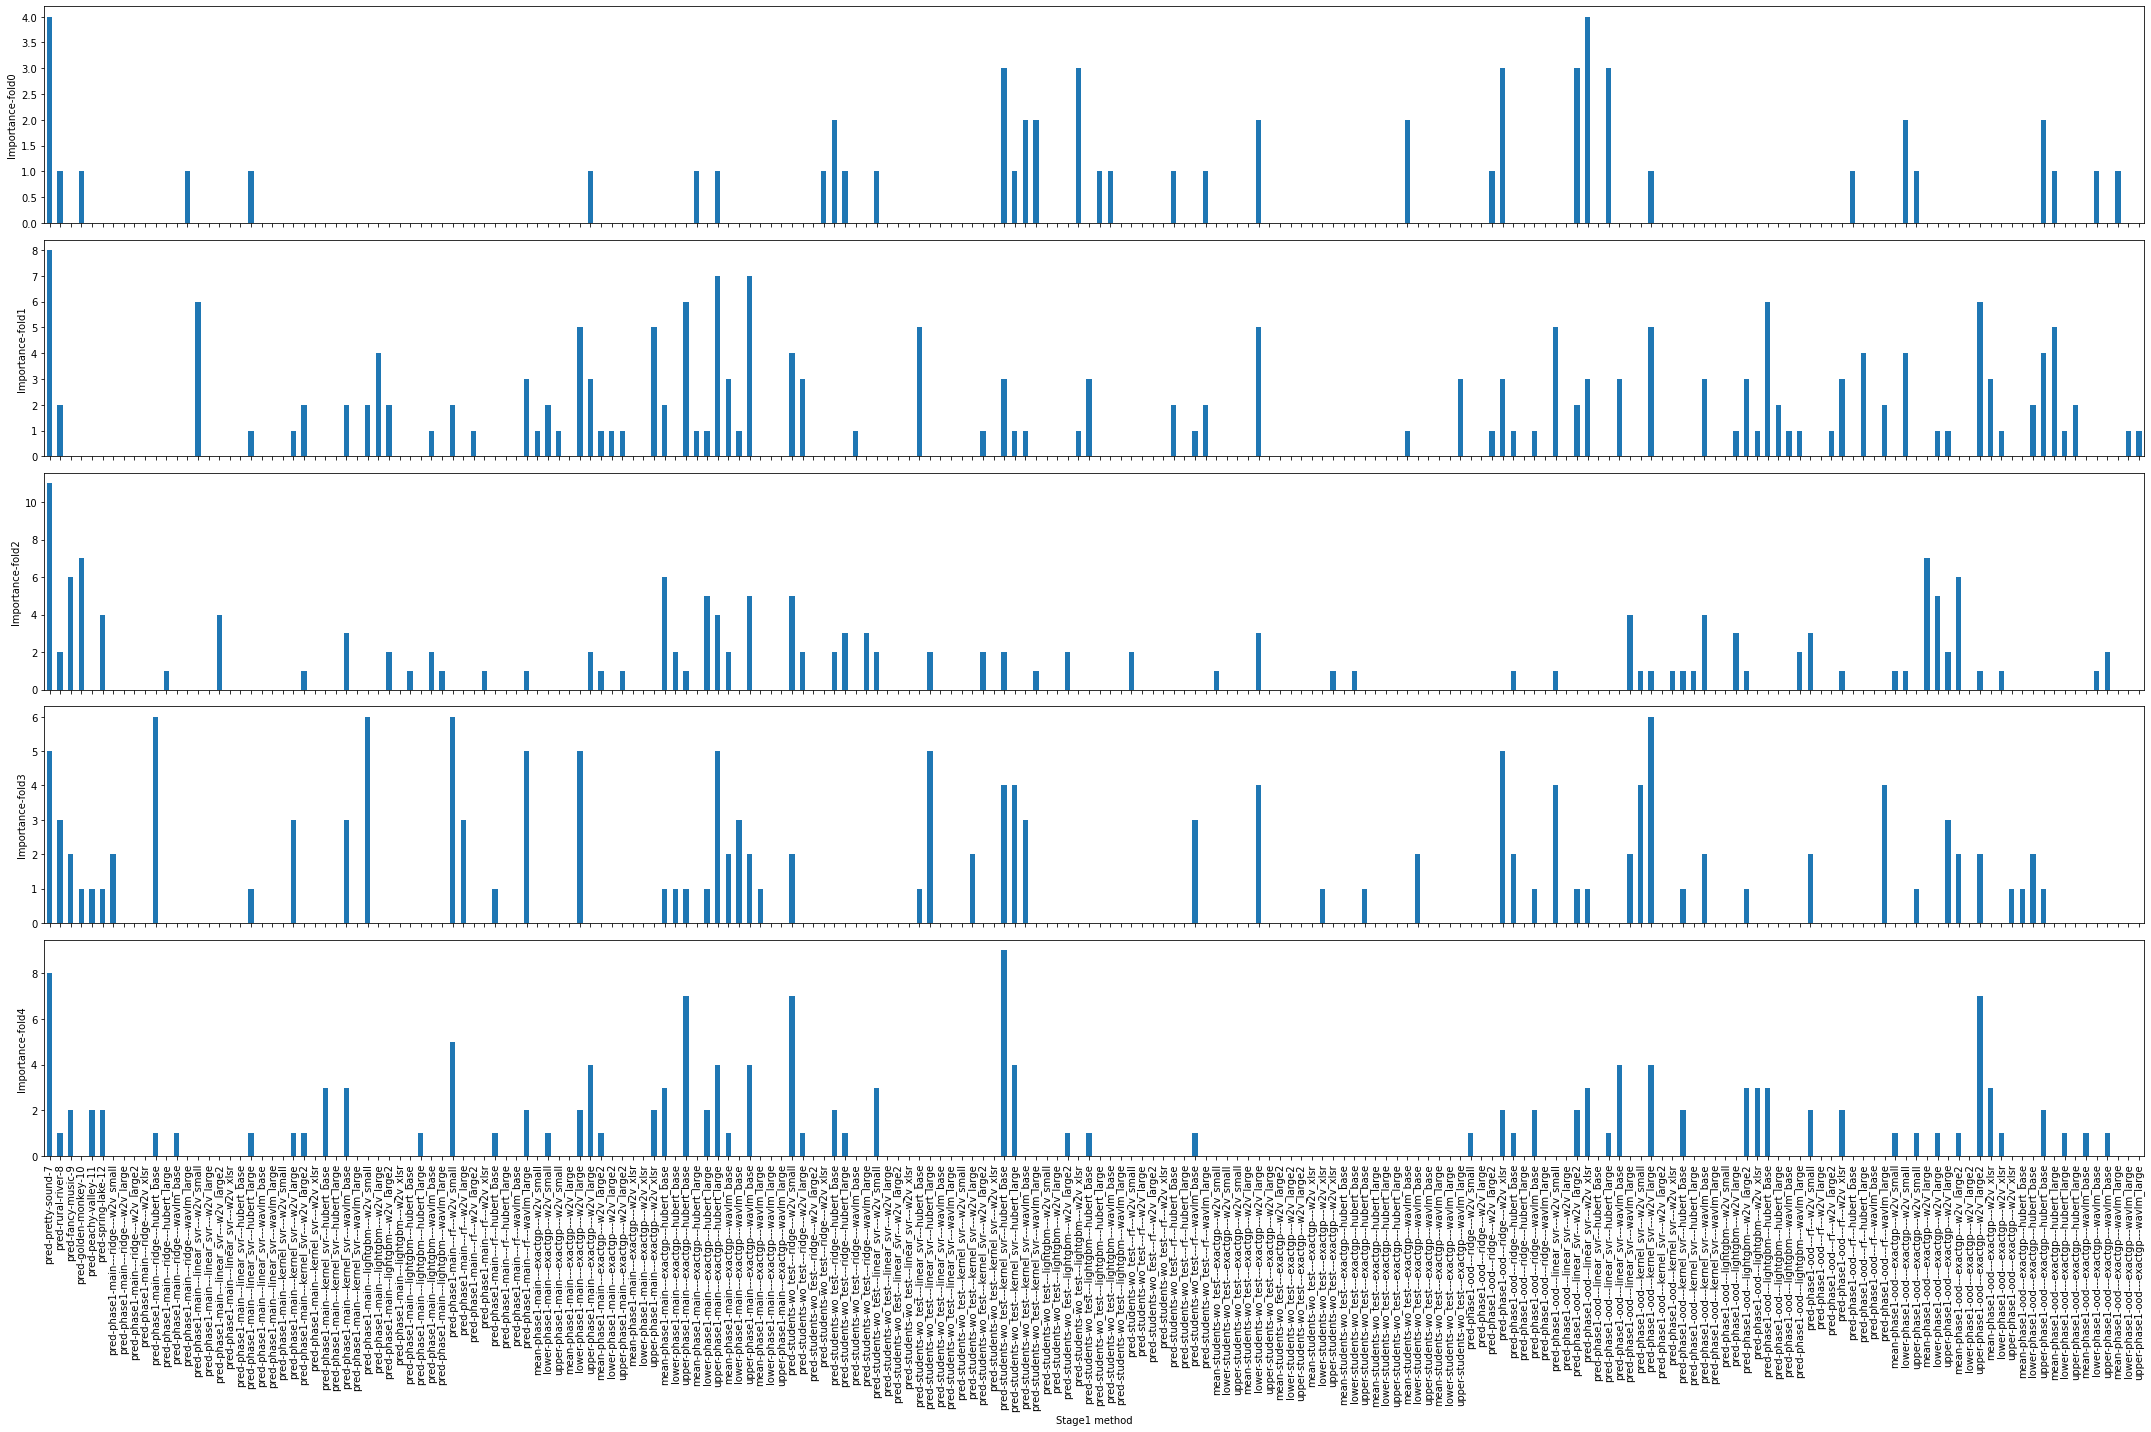

In [67]:
fig, axes = plt.subplots(5,1,figsize=(30,20), sharex=True)
for i in range(5):
    ax = axes[i]
    df_importance.loc[:, i].plot.bar(ax=ax)
    ax.set_ylabel(f'Importance-fold{i}')
    ax.set_xlabel('Stage1 method')
plt.tight_layout()
fig.savefig('./fig/ood-lightgbm_importance.pdf')